In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

In [3]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,input_shape=(img_size, img_size, 3),weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')
vgg.trainable = False
pp.pprint(vgg)

In [ ]:
image1 = input("Enter the file name (without extension) for content image to be used: ")
image2 = input("Enter the file name (without extension) for style image to be used: ")
# both, content & style image should be where your notebook is located. You can also use a custom path if the images are located elsewhere.

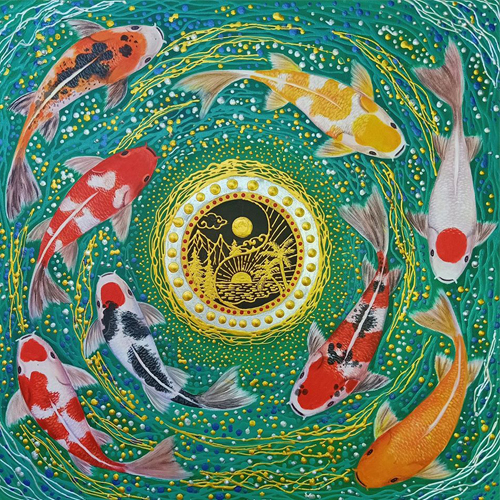

In [4]:
content_image = Image.open(f"{image1}.jpg") 
content_image

In [5]:
def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.transpose(a_C)
    a_G_unrolled = tf.transpose(a_G)
    J_content = (1/ (4* n_H * n_W * n_C)) * tf.reduce_sum(tf.pow((a_G_unrolled - a_C_unrolled), 2))
    return J_content

In [6]:
def gram_matrix(A):
    GA = tf.matmul(A,tf.transpose(A))
    return GA

In [7]:
def compute_layer_style_cost(a_S, a_G):
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S = tf.transpose(tf.reshape(a_S,[n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,[n_H*n_W,n_C]))
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    J_style_layer = (1./(4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS - GG), 2))
    return J_style_layer

In [8]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [10]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [11]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    J_style = 0
    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer
    return J_style

In [12]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

### Load the Content Image
Load, reshape, and normalize your content image C

(1, 400, 400, 3)


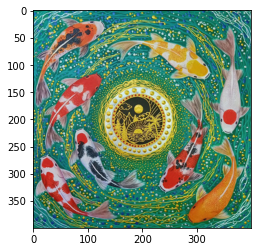

In [13]:
content_image = np.array(Image.open(f"{image1}.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

### Load the Style Image
Load, reshape and normalize your style image

(1, 400, 400, 3)


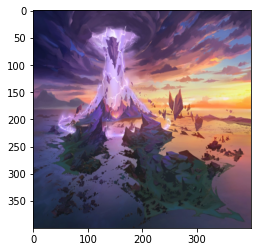

In [14]:
style_image =  np.array(Image.open(f"{image2}.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

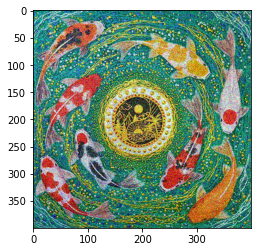

In [15]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
imshow(generated_image.numpy()[0])
plt.show()

## Load Pre trained VGG19 Model
Loads the VGG19 model and returns a list of the outputs for the middle layers.

In [16]:
def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

Now, define the content layer and build the model.

In [17]:
content_layer = [('block5_conv4', 1)]
vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

Save the outputs for the content and style layers in separate variables.

In [18]:
content_target = vgg_model_outputs(content_image)  
style_targets = vgg_model_outputs(style_image)     

In [19]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [20]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

Below are the utils that you will need to display the images generated by the style transfer model.

In [21]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)
        J_style = compute_style_cost(a_S,a_G)
        J_content = compute_content_cost(a_C,a_G)
        J = total_cost(J_content,J_style,10,40)
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))

    return J

In [32]:
generated_image = tf.Variable(generated_image)
J1 = train_step(generated_image)
J2 = train_step(generated_image)

Epoch 0 


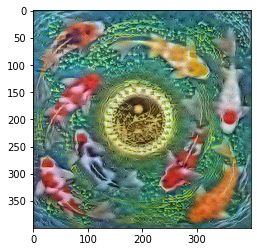

KeyboardInterrupt: 

In [33]:
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show() 

Now, run the following code cell to see the results!

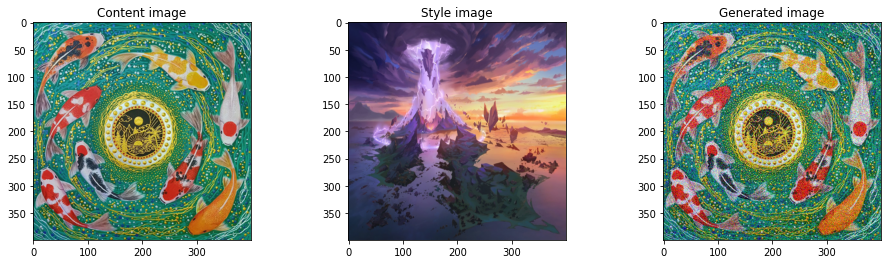

In [24]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()